# Investigate Harmonic Parameters

Look into harmonic parameters for wetland classification. As a first step use random forest for feature selection

In [2]:
import rioxarray
import xarray as xr
import numpy as np
# import holoviews as hv
# import panel as pn
# import param as pm
import joblib

from pathlib import Path

# from holoviews.operation.datashader import regrid
from eotransform_pandas.filesystem.gather import gather_files
from eotransform_pandas.filesystem.naming.geopathfinder_conventions import yeoda_naming_convention
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

from rattlinbog.loaders import load_harmonic_orbits

# hv.extension('bokeh')

## Look at Data

Visualize harmonic parameters to get a feel for it

In [3]:
PARAMETER_DS_ZARR = Path("/eodc/private/tuwgeo/users/braml/data/wetland/hparam/V1M0R1/EQUI7_EU020M/E051N015T3/SIG0-HPAR-MASK____RAMSAR-AT-01_E051N015T3_EU020M__.zarr")
ROI_ROW_MIN = 8000
ROI_ROW_MAX = 10000
ROI_COL_MIN = 8000
ROI_COL_MAX = 10000

In [4]:
hparam_ds = xr.open_zarr(PARAMETER_DS_ZARR)
hparam_ds

<xarray.Dataset>
Dimensions:          (axes: 2, y: 15000, x: 15000, parameter: 9, pos: 10000)
Coordinates:
  * axes             (axes) <U1 'y' 'x'
    band             int64 ...
  * parameter        (parameter) object 'SIG0-HPAR-C1' ... 'SIG0-HPAR-STD'
  * pos              (pos) int64 0 1 2 3 4 5 6 ... 9994 9995 9996 9997 9998 9999
  * x                (x) float64 5.1e+06 5.1e+06 5.1e+06 ... 5.4e+06 5.4e+06
  * y                (y) float64 1.8e+06 1.8e+06 1.8e+06 ... 1.5e+06 1.5e+06
Data variables:
    mask             (y, x) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    params           (parameter, y, x) float32 dask.array<chunksize=(9, 1000, 1000), meta=np.ndarray>
    sampled_indices  (axes, pos) int64 dask.array<chunksize=(2, 10000), meta=np.ndarray>
    spatial_ref      int64 ...

In [5]:
hparam_ds_roi = hparam_ds.isel(y=slice(ROI_ROW_MIN, ROI_ROW_MAX), x=slice(ROI_COL_MIN, ROI_COL_MAX))
hparam_ds_roi

<xarray.Dataset>
Dimensions:          (axes: 2, y: 2000, x: 2000, parameter: 9, pos: 10000)
Coordinates:
  * axes             (axes) <U1 'y' 'x'
    band             int64 ...
  * parameter        (parameter) object 'SIG0-HPAR-C1' ... 'SIG0-HPAR-STD'
  * pos              (pos) int64 0 1 2 3 4 5 6 ... 9994 9995 9996 9997 9998 9999
  * x                (x) float64 5.26e+06 5.26e+06 5.26e+06 ... 5.3e+06 5.3e+06
  * y                (y) float64 1.64e+06 1.64e+06 1.64e+06 ... 1.6e+06 1.6e+06
Data variables:
    mask             (y, x) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    params           (parameter, y, x) float32 dask.array<chunksize=(9, 1000, 1000), meta=np.ndarray>
    sampled_indices  (axes, pos) int64 dask.array<chunksize=(2, 10000), meta=np.ndarray>
    spatial_ref      int64 ...

In [25]:
hparam_ds_roi.drop_vars(['sampled_indices', 'pos']).drop_dims('axes')

<xarray.Dataset>
Dimensions:      (y: 2000, x: 2000, parameter: 9)
Coordinates:
    band         int64 ...
  * parameter    (parameter) object 'SIG0-HPAR-C1' ... 'SIG0-HPAR-STD'
  * x            (x) float64 5.26e+06 5.26e+06 5.26e+06 ... 5.3e+06 5.3e+06
  * y            (y) float64 1.64e+06 1.64e+06 1.64e+06 ... 1.6e+06 1.6e+06
Data variables:
    mask         (y, x) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    params       (parameter, y, x) float32 dask.array<chunksize=(9, 1000, 1000), meta=np.ndarray>
    spatial_ref  int64 ...

In [6]:
from rattlinbog.io_xarray.store_as_compressed_zarr import store_as_compressed_zarr

store_as_compressed_zarr(hparam_ds_roi.drop_vars(['sampled_indices', 'pos']).drop_dims('axes'), "/eodc/private/tuwgeo/users/braml/data/wetland/hparam/V1M0R1/EQUI7_EU020M/E051N015T3/SIG0-HPAR-MASK____RAMSAR-AT-01-ROI_E051N015T3_EU020M__.zarr")

In [18]:
class Explorer(pm.Parameterized):
    parameter = pm.Integer(0, bounds=(0, 8))
    mask_opacity = pm.Magnitude(0.25)
    
    @pm.depends('parameter')
    def image(self):
        return hv.Image(hparam_ds_roi['params'].isel(parameter=self.parameter))
    
    @pm.depends('mask_opacity')
    def mask(self):
        return hv.Image(hparam_ds_roi['mask']).opts(alpha=self.mask_opacity)

    def viewable(self, **kwargs):
        return hv.DynamicMap(self.image).opts(cmap='RdBu', colorbar=True) * hv.DynamicMap(self.mask)

In [57]:
# explorer = Explorer(name='')

In [58]:
# panel = pn.Column(explorer.viewable().opts(frame_width=800, aspect='equal'), 
#                   pn.Param(explorer.param))
# panel.servable()

Column
    [0] HoloViews(DynamicMap)
    [1] Param(Explorer)

In [5]:
#with dask.config.set(scheduler=client):
wet_land_indices = np.nonzero(hparam_ds_roi['mask'].fillna(0)).values
not_wl_indices = np.nonzero(np.logical_not(hparam_ds_roi['mask'].fillna(0))).values

In [6]:
wet_land_indices.shape

(2, 193524)

In [7]:
not_wl_indices.shape

(2, 446476)

In [12]:
wl_choices = np.arange(wet_land_indices.shape[1])
np.random.shuffle(wl_choices)
not_wl_choices = np.arange(not_wl_indices.shape[1])
np.random.shuffle(not_wl_choices)
not_wl_choices = not_wl_choices[:wet_land_indices.shape[1]]

In [13]:
balanced_samples = np.concatenate([wet_land_indices[:, wl_choices], 
                                   not_wl_indices[:, not_wl_choices]], axis=1)
balanced_samples

array([[622, 516, 459, ..., 473, 485, 363],
       [382, 540,  18, ..., 157, 248, 736]])

In [14]:
samples = hparam_ds_roi['params'].isel(y=xr.DataArray(balanced_samples[0], dims="samples"), 
                                       x=xr.DataArray(balanced_samples[1], dims="samples"))
samples

<xarray.DataArray 'params' (parameter: 9, samples: 387048)>
dask.array<transpose, shape=(9, 387048), dtype=float32, chunksize=(9, 387048), chunktype=numpy.ndarray>
Coordinates:
    band       int64 ...
  * parameter  (parameter) object 'SIG0-HPAR-C1' ... 'SIG0-HPAR-STD'
    x          (samples) float64 5.288e+06 5.291e+06 ... 5.285e+06 5.295e+06
    y          (samples) float64 1.608e+06 1.61e+06 ... 1.61e+06 1.613e+06
Dimensions without coordinates: samples

In [15]:
labels = hparam_ds_roi['mask'].fillna(0).isel(y=xr.DataArray(balanced_samples[0], dims="samples"), 
                                              x=xr.DataArray(balanced_samples[1], dims="samples"))
labels

<xarray.DataArray 'mask' (samples: 387048)>
dask.array<vindex-merge, shape=(387048,), dtype=float32, chunksize=(387048,), chunktype=numpy.ndarray>
Coordinates:
    band     int64 ...
    x        (samples) float64 5.288e+06 5.291e+06 ... 5.285e+06 5.295e+06
    y        (samples) float64 1.608e+06 1.61e+06 ... 1.61e+06 1.613e+06
Dimensions without coordinates: samples
Attributes:
    grid_mapping:  spatial_ref

In [18]:
import dask

param_space = {
    'n_estimators': [10, 20, 50, 80, 100, 150, 200, 500, 1000],
    'criterion': ["gini", "entropy", "log_loss"],
    'min_samples_split': [2, 3, 4, 10],
    'max_features': ["sqrt", "log2", None],
}

clf = RandomForestClassifier()
search = RandomizedSearchCV(clf, param_space, cv=3, n_iter=2, n_jobs=-1)
fitted = search.fit(samples.T, labels)

print(fitted)

/eodc/private/tuwgeo/users/braml/code/use-case-wetland-water-stress/venv/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
fitted.best_params_

In [19]:
score = fitted.score(test_x.T.data, test_y.data)
score

0.8688328062669229

In [51]:
def estimate(a, model):
    p = model.predict(a.reshape(-1, a.shape[-1]))
    return p.reshape(a.shape[:2])

estimated = xr.apply_ufunc(estimate, hparam_ds_roi['params'], input_core_dims=[['parameter']], 
                           kwargs=dict(model=fitted), 
                           dask='parallelized', output_dtypes=np.float32)
estimated

<xarray.DataArray 'params' (y: 800, x: 800)>
dask.array<transpose, shape=(800, 800), dtype=float32, chunksize=(800, 800), chunktype=numpy.ndarray>
Coordinates:
    band     int64 1
  * x        (x) float64 5.28e+06 5.28e+06 5.28e+06 ... 5.296e+06 5.296e+06
  * y        (y) float64 1.62e+06 1.62e+06 1.62e+06 ... 1.604e+06 1.604e+06

In [62]:
def estimate_xr(ax, model):
    p = model.predict(ax.values.T.reshape(-1, ax.shape[0]))
    return xr.DataArray(p.reshape(ax.shape[1:]).T, 
                        dims=['y', 'x'], coords={'y': ax.coords['y'],
                                                 'x': ax.coords['x']})

template = xr.DataArray(hparam_ds['mask'].data, 
                        dims=['y', 'x'], coords={'y': hparam_ds.coords['y'],
                                                 'x': hparam_ds.coords['x']})
estimated_blk = xr.map_blocks(estimate_xr, hparam_ds['params'], kwargs=dict(model=fitted),
                             template=template)
estimated_blk

<xarray.DataArray 'open_dataset-2c8790d370ccfb9083e189e3cfbeba5emask-87fd8a1db6b7f81fd1b97f4bd2f282ff' (
                                                                                                        y: 15000,
                                                                                                        x: 15000)>
dask.array<<this-array>-estimate_xr, shape=(15000, 15000), dtype=float32, chunksize=(1000, 1000), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float64 1.8e+06 1.8e+06 1.8e+06 ... 1.5e+06 1.5e+06 1.5e+06
  * x        (x) float64 5.1e+06 5.1e+06 5.1e+06 ... 5.4e+06 5.4e+06 5.4e+06

2022-11-24 22:56:22,949 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client


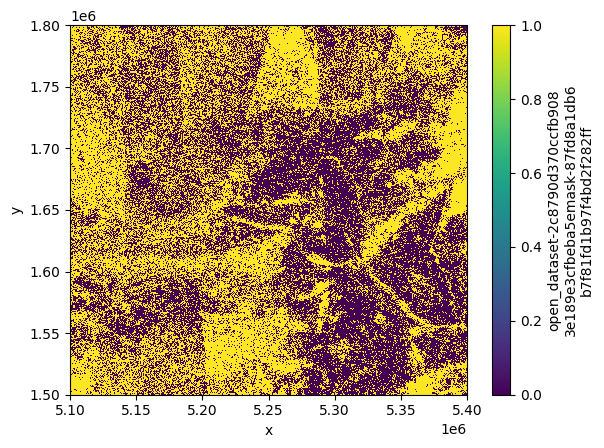

In [64]:
pred_array = estimated_blk.load(scheduler='processes')
pred_array.plot.imshow()